In [1]:
# Testing for GPU availability
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


**1-Downloading Dataset**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pickle
# The classes Sequential and Dense are used to specify the nodes, connections, specifications of the neural network.
import keras
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from scipy import integrate
%matplotlib inline
import os,random
#os.environ["KERAS_BACKEND"] = "theano"
os.environ["KERAS_BACKEND"] = "tensorflow"
#os.environ["THEANO_FLAGS"]  = "device=cuda,floatX=float32"
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, random, sys, keras


Using TensorFlow backend.


In [0]:
# download RML2016.10b.dat dataset
path_ = "drive/My Drive/RML2016.10b.dat"
u = pickle._Unpickler(open(path_,"rb"))
u.encoding = 'latin1'
p = u.load()
  

extracting data

In [4]:
#from paper
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], p.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(p[(mod,snr)])
        for i in range(p[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
print(X.shape)

(1200000, 2, 128)


In [0]:
print("length = " ,len(p.keys()))
unique_keys = set()
for dict_ in p.keys():
  x = list(dict_)[0]
  unique_keys.add(x)
print(unique_keys)

unique_values = set()
for dict_ in p.keys():
  x = list(dict_)[1]
  unique_values.add(x)
print(unique_values)


for dict_ in p.keys():
  print(dict_)

In [0]:
'''
we have 10 modulations [{'QAM64', 'WBFM', 'CPFSK', 'PAM4', 'GFSK', '8PSK', 'QPSK', 'BPSK', 'AM-DSB', 'QAM16'}]
each modulation has 20 SNR values in range [{0, 2, 4, 6, 8, 10, -20, 12, -18, 14, -16, 16, 18, -14, -12, -10, -8, -6, -4, -2}]
each SNR value has 6000 samples
so -> p['modulation_type','SNR_value'].shape = 6000x2x128
p['QAM64',2] = 6000x2x128

total number of samples = 10 modulation * 20 SNR * 6000 = 1,200,000 sample
verified by X.shape = 1,200,000

'''


print(p['QAM64',2])

In [0]:
ds = np.diff(np.array(X))
ds =np.concatenate((np.zeros((1200000,2,1)), ds), axis=2)

In [0]:
#test = integrate.cumtrapz(np.array([1,2,3,4,5,6]))  # (1+2)-((1+2)/2) = 1.5 , (1+2+3)-((1+2+3)//3) = 4,(1+2+3+4)-((1+2+3+4)/4) = 7.5 ...
integrate_s =integrate.cumtrapz(np.array(X),initial = 0)

In [0]:
combined_Data=np.empty((1200000,6,128))
length_combined_data = len(combined_Data)
for (i) in range(length_combined_data):
    combined_Data[i]=np.vstack((X[i],X_driv[i],S[i]))

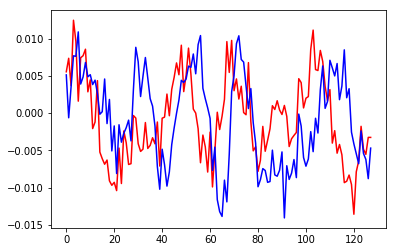

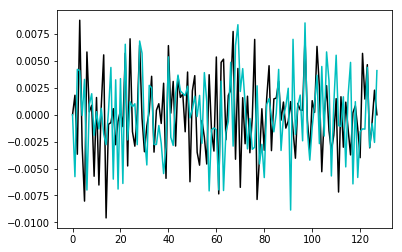

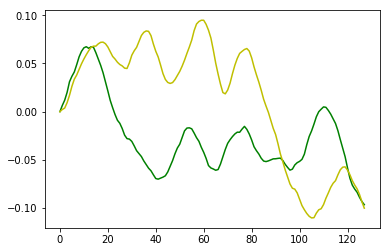

In [11]:
x = np.arange(0,128)
plt.plot(x,X[64000][0],'r')
plt.plot(x,X[64000][1],'b')
plt.show()
plt.figure()
plt.plot(x,ds[64000][0],'k')
plt.plot(x,ds[64000][1],'c')
plt.show()
plt.figure()
plt.plot(x,integrate_s[64000][0],'g')
plt.plot(x,integrate_s[64000][1],'y')
plt.show()

In [0]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = n_examples * 0.5
train_idx = np.random.choice(range(0,n_examples), size= int(n_train), replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
#changed from x to combined data
#X_train = combined_Data[train_idx]
#X_test =  combined_Data[test_idx]
X_train = X[train_idx]
X_test =  X[test_idx]

one hot encoding for multiclass classification since there are 11 classes (11 modulation techniques)

In [0]:
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1 
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

In [14]:
in_shp = list(X_train.shape[1:])
print (X_train.shape, in_shp)
classes = mods

(600000, 2, 128) [2, 128]


In [0]:
# Set up some params 
nb_epoch = 100    # number of epochs to train on
batch_size = 2000  # training batch size

In [16]:
#fully connected neural network
dr = 0.1
model1 = keras.models.Sequential()
model1.add(Reshape(in_shp+[1], input_shape=in_shp))
model1.add(Dropout(dr))
model1.add(Flatten())
model1.add(Dense(128, activation='relu', kernel_initializer='he_normal', name="dense1"))
model1.add(Dropout(dr))
model1.add(Dense(128, activation='relu', kernel_initializer='he_normal', name="dense2"))
model1.add(Dropout(dr))
model1.add(Dense(64, activation='relu', kernel_initializer='he_normal', name="dense3"))
model1.add(Dropout(dr))
model1.add(Dense(64, activation='relu', kernel_initializer='he_normal', name="dense4"))
model1.add(Dropout(dr))
model1.add(Dense( len(classes), kernel_initializer='he_normal', name="dense5" ))
model1.add(Activation('softmax'))
model1.add(Reshape([len(classes)]))
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()

# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'convmodrecnets_CNN2_0.5.wts.h5'
nn =model1.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
     validation_split=0.05,
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
# we re-load the best weights once training is finished
model1.load_weights(filepath)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 2, 128, 1)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 128, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense1 (Dense)               (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense2 (Dense)       

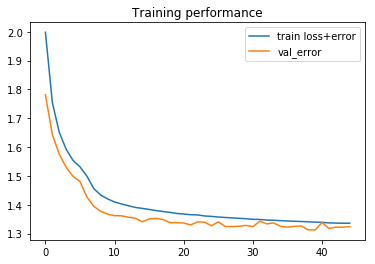

In [17]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(nn.epoch, nn.history['loss'], label='train loss+error')
plt.plot(nn.epoch, nn.history['val_loss'], label='val_error')
plt.legend()

In [18]:
score = model1.evaluate(X_test, Y_test, batch_size=batch_size)
print(model1.metrics_names)
print (score)

600000/600000 [==============================] - 3s 4us/step
['loss', 'acc']
[1.305037109243373, 0.4502149995175811]


In [19]:
import keras.models as models
# Build VT-CNN2 Neural Net model using Keras primitives -- 
#  - Reshape [N,2,128] to [N,1,2,128] on input
#  - Pass through 2 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization
 
dr = 0.1 # dropout rate (%)
model = keras.models.Sequential()
model.add(Reshape(in_shp+[1], input_shape=in_shp))
model.add(ZeroPadding2D((0, 2)))
model.add(Conv2D(64, (1, 3),padding='valid', activation="relu", name="conv1",kernel_initializer='glorot_uniform',data_format="channels_last"))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Conv2D(16,(2, 3), padding='valid', activation="relu", name="conv2", kernel_initializer='glorot_uniform',data_format="channels_last"))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_normal', name="dense1"))
model.add(Dropout(dr))
model.add(Dense( len(classes), kernel_initializer='he_normal', name="dense2" ))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'convmodrecnets_CNN2_0.5.wts.h5'
cnn = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
     validation_split=0.05,
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
    ])
# we re-load the best weights once training is finished
model.load_weights(filepath)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 2, 128, 1)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 2, 132, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 2, 130, 64)        256       
_________________________________________________________________
dropout_6 (Dropout)          (None, 2, 130, 64)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 2, 134, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 132, 16)        6160      
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 132, 16)        0         
__________

In [20]:
scscore = model.evaluate(X_test, Y_test, batch_size=batch_size)
print(model.metrics_names)
print (scscore)

600000/600000 [==============================] - 3s 6us/step
['loss', 'acc']
[1.0432669969617079, 0.5624616669832418]


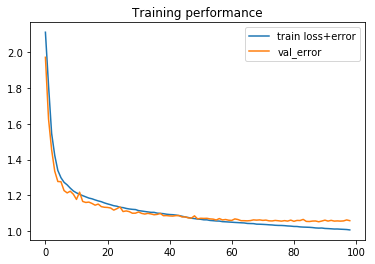

In [21]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(cnn.epoch, cnn.history['loss'], label='train loss+error')
plt.plot(cnn.epoch, cnn.history['val_loss'], label='val_error')
plt.legend()

In [0]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

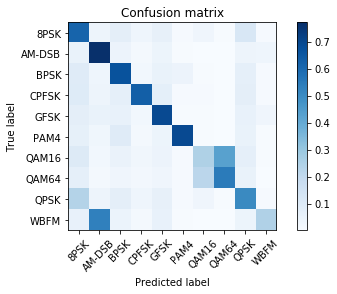

In [23]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)
# on the right its a color chart to indicate that the darker the color the easier and thee most to identify

@SNR =  -20  Overall Accuracy:  0.10527018903212879
@SNR =  -18  Overall Accuracy:  0.10884671923025524
@SNR =  -16  Overall Accuracy:  0.11330689505781984
@SNR =  -14  Overall Accuracy:  0.1352174932190336
@SNR =  -12  Overall Accuracy:  0.16834657232494493
@SNR =  -10  Overall Accuracy:  0.26196742063359874
@SNR =  -8  Overall Accuracy:  0.38369893472272926
@SNR =  -6  Overall Accuracy:  0.518288405651869
@SNR =  -4  Overall Accuracy:  0.6272406210435131
@SNR =  -2  Overall Accuracy:  0.7189803028272812
@SNR =  0  Overall Accuracy:  0.7823547185013596
@SNR =  2  Overall Accuracy:  0.8035619174434088
@SNR =  4  Overall Accuracy:  0.808420072495095
@SNR =  6  Overall Accuracy:  0.8132560066280033
@SNR =  8  Overall Accuracy:  0.8162113718591297
@SNR =  10  Overall Accuracy:  0.8162287994679082
@SNR =  12  Overall Accuracy:  0.8156580786898342
@SNR =  14  Overall Accuracy:  0.8159893846409023
@SNR =  16  Overall Accuracy:  0.8153250825632985
@SNR =  18  Overall Accuracy:  0.815348603912

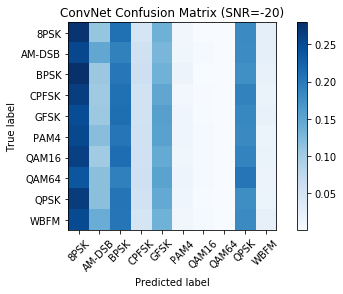

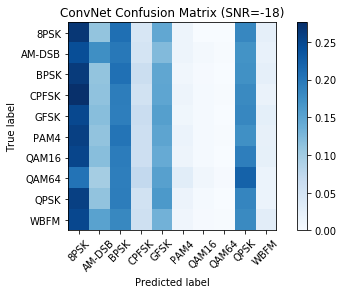

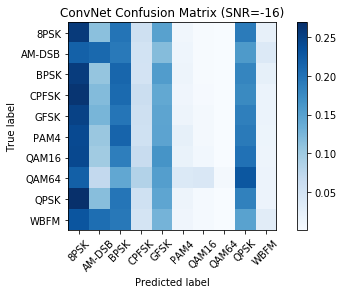

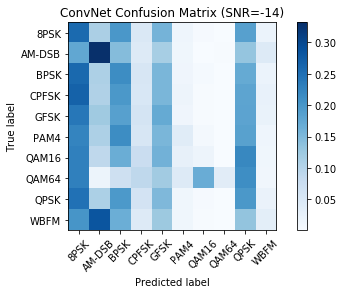

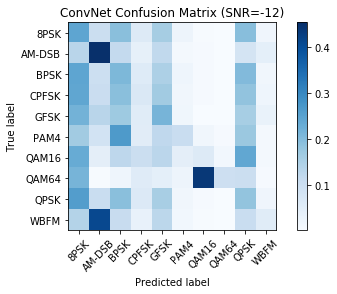

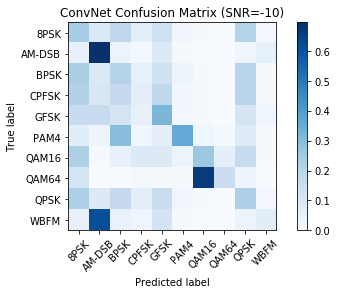

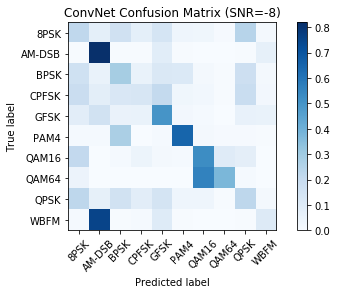

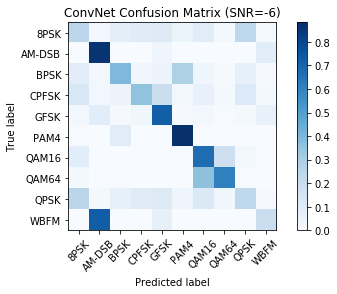

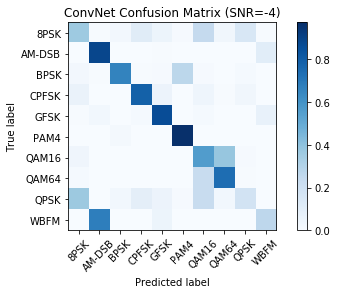

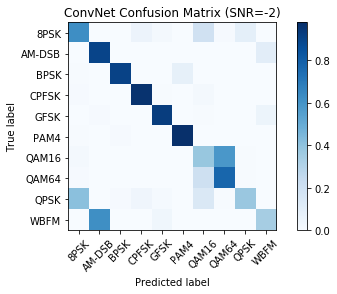

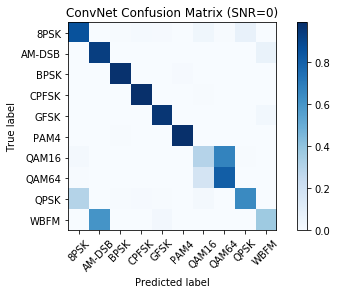

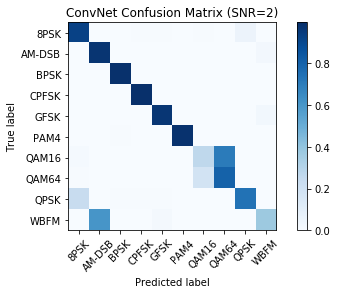

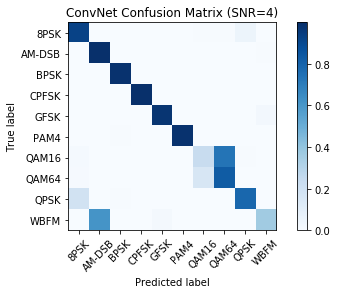

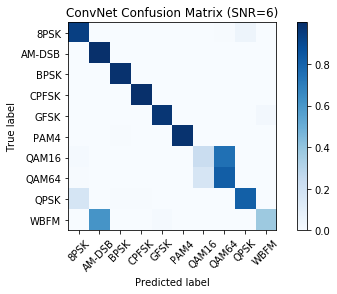

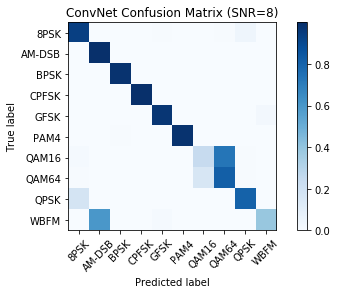

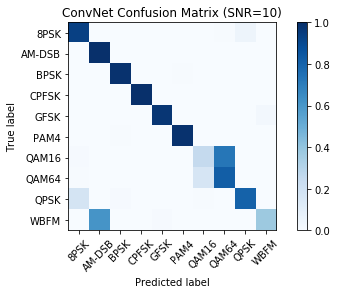

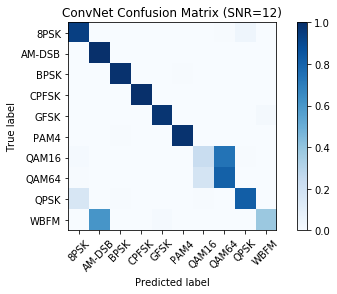

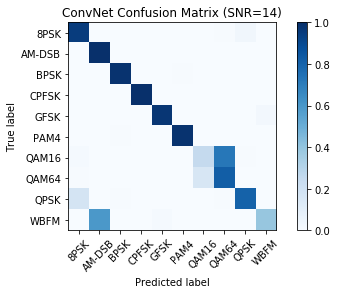

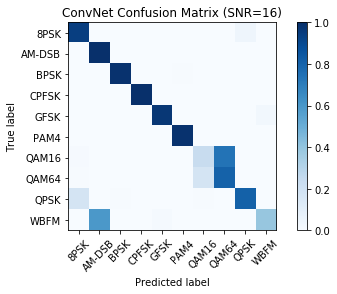

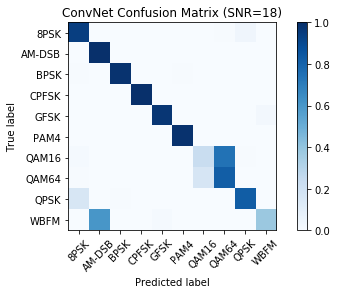

In [24]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print ("@SNR = ",snr," Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

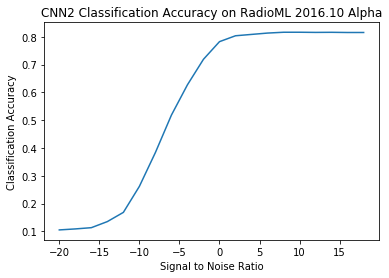

In [25]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")